In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchsummary import summary
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np
from tqdm import tqdm
import random
from torch.optim.lr_scheduler import CyclicLR

In [2]:
# Setting a Random Seed for reproducibility
SEED = 1234321

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Network architecture definition

*Reference:* The following block of code is adapted from the repository: https://github.com/kuangliu/pytorch-cifar

In [3]:
'''ResNet in PyTorch.

For Pre-activation ResNet, see 'preact_resnet.py'.

Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=2, dropout_rate=0.15):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.dropout = nn.Dropout(dropout_rate)  # Add dropout
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)  # Apply dropout after activation
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out




class Bottleneck(nn.Module):
    expansion = 2

    def __init__(self, in_planes, planes, stride=1, dropout_rate=0.12):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.dropout1 = nn.Dropout(dropout_rate)  # Add dropout
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.dropout2 = nn.Dropout(dropout_rate)  # Add another dropout
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.dropout1(out)  # Apply dropout after first activation
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.dropout2(out)  # Apply dropout after second activation
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 42

        self.conv1 = nn.Conv2d(3, 42, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(42)
        self.layer1 = self._make_layer(block, 42, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 84, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 168, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 336, num_blocks[2], stride=2)

        self.linear = nn.Linear(336*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

def test():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())

# test()


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
layers=[1, 1, 1, 1]

net = ResNet18().to(device)
summary(net, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 42, 32, 32]           1,134
       BatchNorm2d-2           [-1, 42, 32, 32]              84
            Conv2d-3           [-1, 42, 32, 32]          15,876
       BatchNorm2d-4           [-1, 42, 32, 32]              84
           Dropout-5           [-1, 42, 32, 32]               0
            Conv2d-6           [-1, 42, 32, 32]          15,876
       BatchNorm2d-7           [-1, 42, 32, 32]              84
        BasicBlock-8           [-1, 42, 32, 32]               0
            Conv2d-9           [-1, 42, 32, 32]          15,876
      BatchNorm2d-10           [-1, 42, 32, 32]              84
          Dropout-11           [-1, 42, 32, 32]               0
           Conv2d-12           [-1, 42, 32, 32]          15,876
      BatchNorm2d-13           [-1, 42, 32, 32]              84
       BasicBlock-14           [-1, 42,

Trainable parameters ~4.8M

## Data Augmentation Step

In [6]:
from torch.utils.data import ConcatDataset
# Load the dataset
# Defining Transformers for train and test set differently
train_transform = transforms.Compose([
    transforms.RandomRotation(10),  # Random rotation within 5 degrees
    transforms.RandomHorizontalFlip(0.5),  # 50% chance of horizontal flip
    transforms.RandomCrop(32, padding=4),  # Random crop with padding
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Randomly jitter color properties
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random translation of 10%
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])
# Normal transformation for original images
normal_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])





train_dataset_transformed = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
train_dataset_normal = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=normal_transform)

# Concatenate the two datasets
# This steps adds transformed version of the CIFAR10 dataset to itself - increasing the number of datapoints that our model can learn from
combined_dataset = ConcatDataset([train_dataset_transformed, train_dataset_normal])
train_loader = torch.utils.data.DataLoader(combined_dataset, batch_size=100, shuffle=True)
train_dataset=combined_dataset




# Concatenate the two datasets
test_transform = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean = [0.4914, 0.4822, 0.4465],
                                                std = [0.2023, 0.1994, 0.2010])
                       ])
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=6)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


/home/sa8237/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


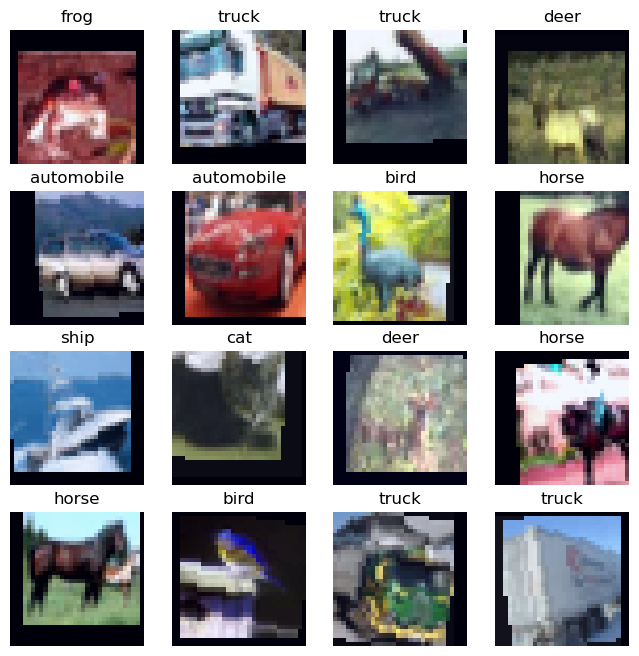

In [7]:
# Checking the data is loaded correctly
def plot_images(images, labels, classes, normalize = False):
    n_images = len(images)
    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))
    fig = plt.figure(figsize = (8, 8))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)       
        image = images[i]
        if normalize:
            image_min = image.min()
            image_max = image.max()
            image.clamp_(min = image_min, max = image_max)
            image.add_(-image_min).div_(image_max - image_min + 1e-5)
        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(classes[labels[i]])
        ax.axis('off')

N_IMAGES = 16
images, labels = zip(*[(image, label) for image, label in [train_dataset[i] for i in range(N_IMAGES)]])
classes = test_dataset.classes
plot_images(images, labels, classes, normalize = True)

## ResNet Training

In [8]:
def train(data_loader, model, criterion, optimizer, scheduler = None, early_stop=None):
    learning_rate_tracker = {}
    epoch_correct = 0
    running_loss = 0.0
    model.train()
    for i, (images, labels) in tqdm(enumerate(data_loader)):
        learning_rate_tracker[i] = optimizer.param_groups[0]['lr']

        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        predicted = torch.max(outputs.data, 1)[1]
        epoch_correct += (predicted == labels).sum().item()

        if early_stop and i==early_stop:
            break

        loss.backward()
        optimizer.step()
        if scheduler:
            scheduler.step()


    return epoch_correct , running_loss, learning_rate_tracker

def evaluate(data_loader, model, criterion):
    epoch_correct = 0
    running_loss = 0.0
    y_true = []
    y_pred = []
    model.eval()
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            epoch_correct += (predicted == labels).sum().item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    return epoch_correct, running_loss, y_true, y_pred

In [9]:
# Defining ranges for learning rate for the scheduler to cycle through
lr_min = 1e-6
lr_max = 1e-2
epochs = 80
step_size = (len(train_dataset)/32) // 2

model = net
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, betas=(0.9, 0.999), weight_decay=1e-2)
scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=lr_min, max_lr=lr_max, step_size_up=step_size, step_size_down=step_size, gamma=0.9999, mode="exp_range", cycle_momentum=False)
lr_tracker = {}

train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []
y_pred = []
y_true = []
best_valid_loss = float('inf')

# Model training loop
for epoch in range(epochs):
    print(f"Epoch: {epoch+1}/{epochs}")
    correct, loss, rate_tracker = train(data_loader=train_loader, model=model, criterion=criterion, optimizer=optimizer, scheduler=scheduler)
    accuracy = correct / len(train_loader.dataset)
    loss = loss / len(train_loader)
    train_loss = loss
    train_acc_history.append(accuracy)
    train_loss_history.append(loss)
    for key in rate_tracker.keys():
        lr_tracker[(epoch,key)] = rate_tracker[key]
    
    # validation phase
    correct, loss, y_true, y_pred = evaluate(data_loader = test_loader, model=model, criterion=criterion)
    validation_accuracy = correct / len(test_loader.dataset)
    validation_loss = loss / len(test_loader)
    print(f"Train Accuracy: {accuracy*100:.2f}%, Train Loss: {train_loss}")
    print(f"Test Accuracy: {validation_accuracy*100:.2f}%, Test Loss: {validation_loss}")
    if validation_loss < best_valid_loss:
        best_valid_loss = validation_loss
        torch.save(model.state_dict(), 'ahzam_net.pt')
    val_acc_history.append(validation_accuracy)
    val_loss_history.append(validation_loss)

Epoch: 1/80


1000it [01:05, 15.28it/s]


Train Accuracy: 51.52%, Train Loss: 1.336574658036232
Test Accuracy: 61.70%, Test Loss: 1.1752302235364913
Epoch: 2/80


1000it [01:01, 16.27it/s]


Train Accuracy: 71.34%, Train Loss: 0.8173257927894593
Test Accuracy: 79.45%, Test Loss: 0.5807479244470596
Epoch: 3/80


1000it [01:01, 16.32it/s]


Train Accuracy: 81.16%, Train Loss: 0.5413931063562631
Test Accuracy: 86.69%, Test Loss: 0.3914210134744644
Epoch: 4/80


1000it [01:01, 16.28it/s]


Train Accuracy: 84.72%, Train Loss: 0.44140750509500504
Test Accuracy: 78.37%, Test Loss: 0.6575774630904198
Epoch: 5/80


1000it [01:01, 16.30it/s]


Train Accuracy: 81.46%, Train Loss: 0.5346139634847641
Test Accuracy: 84.49%, Test Loss: 0.46376505941152574
Epoch: 6/80


1000it [01:01, 16.27it/s]


Train Accuracy: 86.67%, Train Loss: 0.38199026364088057
Test Accuracy: 89.20%, Test Loss: 0.3217538625001907
Epoch: 7/80


1000it [01:01, 16.28it/s]


Train Accuracy: 90.56%, Train Loss: 0.2724947279393673
Test Accuracy: 88.40%, Test Loss: 0.35035266041755675
Epoch: 8/80


1000it [01:01, 16.27it/s]


Train Accuracy: 87.27%, Train Loss: 0.3642859363406897
Test Accuracy: 86.04%, Test Loss: 0.41786556124687196
Epoch: 9/80


1000it [01:01, 16.30it/s]


Train Accuracy: 89.91%, Train Loss: 0.2903059648796916
Test Accuracy: 90.02%, Test Loss: 0.3058163801580667
Epoch: 10/80


1000it [01:01, 16.32it/s]


Train Accuracy: 93.32%, Train Loss: 0.19478425643593072
Test Accuracy: 90.31%, Test Loss: 0.3175213681906462
Epoch: 11/80


1000it [01:01, 16.31it/s]


Train Accuracy: 91.31%, Train Loss: 0.2502302346527576
Test Accuracy: 88.17%, Test Loss: 0.38628264486789704
Epoch: 12/80


1000it [01:01, 16.28it/s]


Train Accuracy: 92.16%, Train Loss: 0.22728665532916784
Test Accuracy: 90.91%, Test Loss: 0.3005538212507963
Epoch: 13/80


1000it [01:01, 16.26it/s]


Train Accuracy: 94.77%, Train Loss: 0.15768161402642727
Test Accuracy: 90.86%, Test Loss: 0.308421965688467
Epoch: 14/80


1000it [01:01, 16.33it/s]


Train Accuracy: 93.68%, Train Loss: 0.1829365954436362
Test Accuracy: 88.29%, Test Loss: 0.40915302097797396
Epoch: 15/80


1000it [01:01, 16.29it/s]


Train Accuracy: 93.57%, Train Loss: 0.18596622339263558
Test Accuracy: 91.06%, Test Loss: 0.30416554898023607
Epoch: 16/80


1000it [01:01, 16.35it/s]


Train Accuracy: 95.45%, Train Loss: 0.1342224498540163
Test Accuracy: 91.41%, Test Loss: 0.3043673560023308
Epoch: 17/80


1000it [01:01, 16.27it/s]


Train Accuracy: 95.13%, Train Loss: 0.14423774081841112
Test Accuracy: 91.09%, Test Loss: 0.32128294348716735
Epoch: 18/80


1000it [01:01, 16.26it/s]


Train Accuracy: 94.64%, Train Loss: 0.15528081665001808
Test Accuracy: 91.70%, Test Loss: 0.3082888545840979
Epoch: 19/80


1000it [01:01, 16.32it/s]


Train Accuracy: 95.97%, Train Loss: 0.11776392064802349
Test Accuracy: 92.17%, Test Loss: 0.2926936363428831
Epoch: 20/80


1000it [01:01, 16.30it/s]


Train Accuracy: 95.92%, Train Loss: 0.11814212757069617
Test Accuracy: 91.39%, Test Loss: 0.3226467636227608
Epoch: 21/80


1000it [01:01, 16.27it/s]


Train Accuracy: 95.50%, Train Loss: 0.1298854426573962
Test Accuracy: 91.85%, Test Loss: 0.3140515570342541
Epoch: 22/80


1000it [01:01, 16.29it/s]


Train Accuracy: 96.31%, Train Loss: 0.10580814968887717
Test Accuracy: 92.50%, Test Loss: 0.29629119373857976
Epoch: 23/80


1000it [01:01, 16.29it/s]


Train Accuracy: 96.51%, Train Loss: 0.10132450895570219
Test Accuracy: 91.73%, Test Loss: 0.31727477490901945
Epoch: 24/80


1000it [01:01, 16.30it/s]


Train Accuracy: 96.19%, Train Loss: 0.11283204473182559
Test Accuracy: 91.77%, Test Loss: 0.30988201074302196
Epoch: 25/80


1000it [01:01, 16.30it/s]


Train Accuracy: 96.66%, Train Loss: 0.0963945308253169
Test Accuracy: 92.31%, Test Loss: 0.2962601174414158
Epoch: 26/80


1000it [01:01, 16.29it/s]


Train Accuracy: 96.88%, Train Loss: 0.08916344170738012
Test Accuracy: 92.18%, Test Loss: 0.3075179207324982
Epoch: 27/80


1000it [01:01, 16.33it/s]


Train Accuracy: 96.56%, Train Loss: 0.09958929998613894
Test Accuracy: 92.31%, Test Loss: 0.30039864763617513
Epoch: 28/80


1000it [01:01, 16.31it/s]


Train Accuracy: 96.93%, Train Loss: 0.08953008667100221
Test Accuracy: 92.56%, Test Loss: 0.2912831737846136
Epoch: 29/80


1000it [01:01, 16.33it/s]


Train Accuracy: 97.20%, Train Loss: 0.0812714231275022
Test Accuracy: 92.62%, Test Loss: 0.29182693012058736
Epoch: 30/80


1000it [01:01, 16.33it/s]


Train Accuracy: 97.01%, Train Loss: 0.08637303393427283
Test Accuracy: 92.29%, Test Loss: 0.32235254473984243
Epoch: 31/80


1000it [01:01, 16.27it/s]


Train Accuracy: 97.11%, Train Loss: 0.08232101397402584
Test Accuracy: 92.65%, Test Loss: 0.2965137982368469
Epoch: 32/80


1000it [01:01, 16.30it/s]


Train Accuracy: 97.26%, Train Loss: 0.07854267194028944
Test Accuracy: 92.48%, Test Loss: 0.30462660506367684
Epoch: 33/80


1000it [01:01, 16.35it/s]


Train Accuracy: 97.21%, Train Loss: 0.07911843884456903
Test Accuracy: 92.51%, Test Loss: 0.30519664600491525
Epoch: 34/80


1000it [01:01, 16.34it/s]


Train Accuracy: 97.29%, Train Loss: 0.07691447038203478
Test Accuracy: 92.69%, Test Loss: 0.29325267031788826
Epoch: 35/80


1000it [01:01, 16.34it/s]


Train Accuracy: 97.53%, Train Loss: 0.07136096272990107
Test Accuracy: 92.68%, Test Loss: 0.29693460278213024
Epoch: 36/80


1000it [01:01, 16.32it/s]


Train Accuracy: 97.44%, Train Loss: 0.07506774850375951
Test Accuracy: 92.62%, Test Loss: 0.306022530272603
Epoch: 37/80


1000it [01:05, 15.32it/s]


Train Accuracy: 97.53%, Train Loss: 0.07199803979415446
Test Accuracy: 92.67%, Test Loss: 0.3002928400412202
Epoch: 38/80


1000it [01:05, 15.15it/s]


Train Accuracy: 97.60%, Train Loss: 0.06830231387773529
Test Accuracy: 92.86%, Test Loss: 0.2959473802894354
Epoch: 39/80


1000it [01:06, 15.10it/s]


Train Accuracy: 97.68%, Train Loss: 0.06701070571271703
Test Accuracy: 92.71%, Test Loss: 0.2981721540540457
Epoch: 40/80


1000it [01:06, 15.13it/s]


Train Accuracy: 97.48%, Train Loss: 0.07070304441917688
Test Accuracy: 92.74%, Test Loss: 0.29479097343981264
Epoch: 41/80


1000it [01:05, 15.16it/s]


Train Accuracy: 97.62%, Train Loss: 0.06737794957263395
Test Accuracy: 92.75%, Test Loss: 0.29562802337110045
Epoch: 42/80


1000it [01:05, 15.18it/s]


Train Accuracy: 97.62%, Train Loss: 0.06739194362191483
Test Accuracy: 92.92%, Test Loss: 0.29646925516426564
Epoch: 43/80


1000it [01:05, 15.22it/s]


Train Accuracy: 97.68%, Train Loss: 0.06658804690139368
Test Accuracy: 92.89%, Test Loss: 0.2992237590253353
Epoch: 44/80


1000it [01:06, 15.13it/s]


Train Accuracy: 97.79%, Train Loss: 0.06562712840456515
Test Accuracy: 92.93%, Test Loss: 0.2980107047408819
Epoch: 45/80


1000it [01:06, 15.12it/s]


Train Accuracy: 97.76%, Train Loss: 0.06469367943750694
Test Accuracy: 92.86%, Test Loss: 0.29957572154700757
Epoch: 46/80


1000it [01:05, 15.15it/s]


Train Accuracy: 97.77%, Train Loss: 0.06371921885572374
Test Accuracy: 92.92%, Test Loss: 0.30073639899492266
Epoch: 47/80


1000it [01:06, 15.10it/s]


Train Accuracy: 97.78%, Train Loss: 0.06344520017132163
Test Accuracy: 92.95%, Test Loss: 0.2966473788768053
Epoch: 48/80


1000it [01:06, 15.15it/s]


Train Accuracy: 97.83%, Train Loss: 0.06184551514382474
Test Accuracy: 92.85%, Test Loss: 0.3010627775639296
Epoch: 49/80


1000it [01:05, 15.17it/s]


Train Accuracy: 97.78%, Train Loss: 0.06255818103440106
Test Accuracy: 92.90%, Test Loss: 0.29785610996186734
Epoch: 50/80


1000it [01:06, 15.15it/s]


Train Accuracy: 97.89%, Train Loss: 0.06054103889828548
Test Accuracy: 92.89%, Test Loss: 0.295642211958766
Epoch: 51/80


1000it [01:06, 15.13it/s]


Train Accuracy: 97.78%, Train Loss: 0.061944916980341075
Test Accuracy: 93.03%, Test Loss: 0.2961942918598652
Epoch: 52/80


1000it [01:06, 15.14it/s]


Train Accuracy: 97.87%, Train Loss: 0.06051450172485784
Test Accuracy: 92.93%, Test Loss: 0.2980334704369307
Epoch: 53/80


1000it [01:06, 15.13it/s]


Train Accuracy: 97.82%, Train Loss: 0.061584018256515265
Test Accuracy: 92.91%, Test Loss: 0.29834667332470416
Epoch: 54/80


1000it [01:06, 15.15it/s]


Train Accuracy: 97.84%, Train Loss: 0.0612443281095475
Test Accuracy: 92.98%, Test Loss: 0.3016344486176968
Epoch: 55/80


1000it [01:06, 15.12it/s]


Train Accuracy: 97.81%, Train Loss: 0.06145412184996531
Test Accuracy: 93.00%, Test Loss: 0.2976470995694399
Epoch: 56/80


1000it [01:06, 15.11it/s]


Train Accuracy: 97.82%, Train Loss: 0.061674776209983975
Test Accuracy: 92.97%, Test Loss: 0.3016202246397734
Epoch: 57/80


1000it [01:05, 15.17it/s]


Train Accuracy: 97.91%, Train Loss: 0.05937294377433136
Test Accuracy: 92.94%, Test Loss: 0.29915823593735696
Epoch: 58/80


1000it [01:05, 15.17it/s]


Train Accuracy: 97.94%, Train Loss: 0.06015165570983663
Test Accuracy: 93.02%, Test Loss: 0.2996195747703314
Epoch: 59/80


1000it [01:06, 15.12it/s]


Train Accuracy: 97.95%, Train Loss: 0.05919489818671718
Test Accuracy: 92.98%, Test Loss: 0.29791697300970554
Epoch: 60/80


1000it [01:05, 15.18it/s]


Train Accuracy: 97.88%, Train Loss: 0.05939483624650165
Test Accuracy: 93.01%, Test Loss: 0.29859383270144463
Epoch: 61/80


1000it [01:05, 15.19it/s]


Train Accuracy: 97.96%, Train Loss: 0.059931719878222794
Test Accuracy: 93.00%, Test Loss: 0.29907814361155033
Epoch: 62/80


1000it [01:06, 15.13it/s]


Train Accuracy: 97.86%, Train Loss: 0.06063844372145832
Test Accuracy: 92.99%, Test Loss: 0.2970248069241643
Epoch: 63/80


1000it [01:06, 15.11it/s]


Train Accuracy: 97.94%, Train Loss: 0.05962553951051086
Test Accuracy: 93.01%, Test Loss: 0.2985542590916157
Epoch: 64/80


1000it [01:05, 15.18it/s]


Train Accuracy: 97.89%, Train Loss: 0.05994629202387296
Test Accuracy: 93.10%, Test Loss: 0.3008408015221357
Epoch: 65/80


1000it [01:05, 15.16it/s]


Train Accuracy: 97.92%, Train Loss: 0.06008161232760176
Test Accuracy: 93.04%, Test Loss: 0.29680527620017527
Epoch: 66/80


1000it [01:05, 15.21it/s]


Train Accuracy: 97.95%, Train Loss: 0.05856970362970605
Test Accuracy: 93.04%, Test Loss: 0.29988211549818516
Epoch: 67/80


1000it [01:05, 15.19it/s]


Train Accuracy: 97.97%, Train Loss: 0.058132616824936124
Test Accuracy: 92.97%, Test Loss: 0.29879370622336865
Epoch: 68/80


1000it [01:05, 15.30it/s]


Train Accuracy: 97.90%, Train Loss: 0.05997897277749144
Test Accuracy: 92.96%, Test Loss: 0.30055667825043203
Epoch: 69/80


1000it [01:05, 15.29it/s]


Train Accuracy: 97.90%, Train Loss: 0.05951475736219436
Test Accuracy: 93.07%, Test Loss: 0.3012327344715595
Epoch: 70/80


1000it [01:06, 15.15it/s]


Train Accuracy: 97.96%, Train Loss: 0.057377344521693886
Test Accuracy: 92.98%, Test Loss: 0.2976356868445873
Epoch: 71/80


1000it [01:06, 15.14it/s]


Train Accuracy: 97.92%, Train Loss: 0.0596495776316151
Test Accuracy: 93.05%, Test Loss: 0.29718513317406176
Epoch: 72/80


1000it [01:05, 15.16it/s]


Train Accuracy: 97.93%, Train Loss: 0.05936007780325599
Test Accuracy: 93.00%, Test Loss: 0.2980153458565474
Epoch: 73/80


1000it [01:05, 15.18it/s]


Train Accuracy: 97.92%, Train Loss: 0.05946697084000334
Test Accuracy: 93.06%, Test Loss: 0.2992698070406914
Epoch: 74/80


1000it [01:05, 15.20it/s]


Train Accuracy: 97.91%, Train Loss: 0.05862920506671071
Test Accuracy: 93.13%, Test Loss: 0.2998325760662556
Epoch: 75/80


1000it [01:06, 15.14it/s]


Train Accuracy: 97.95%, Train Loss: 0.05895936666987836
Test Accuracy: 93.08%, Test Loss: 0.30049701176583765
Epoch: 76/80


1000it [01:05, 15.17it/s]


Train Accuracy: 97.96%, Train Loss: 0.05733465343201533
Test Accuracy: 93.07%, Test Loss: 0.2968007723987103
Epoch: 77/80


1000it [01:05, 15.19it/s]


Train Accuracy: 97.98%, Train Loss: 0.057775719627738
Test Accuracy: 93.01%, Test Loss: 0.3000532678514719
Epoch: 78/80


1000it [01:05, 15.17it/s]


Train Accuracy: 97.92%, Train Loss: 0.059395872174762186
Test Accuracy: 93.10%, Test Loss: 0.2993043555319309
Epoch: 79/80


1000it [01:05, 15.16it/s]


Train Accuracy: 98.00%, Train Loss: 0.05787556338682771
Test Accuracy: 92.99%, Test Loss: 0.30023327108472586
Epoch: 80/80


1000it [01:06, 15.10it/s]


Train Accuracy: 97.98%, Train Loss: 0.057561185220256446
Test Accuracy: 93.02%, Test Loss: 0.2988829309493303


### Plotting accuracy and loss against epochs

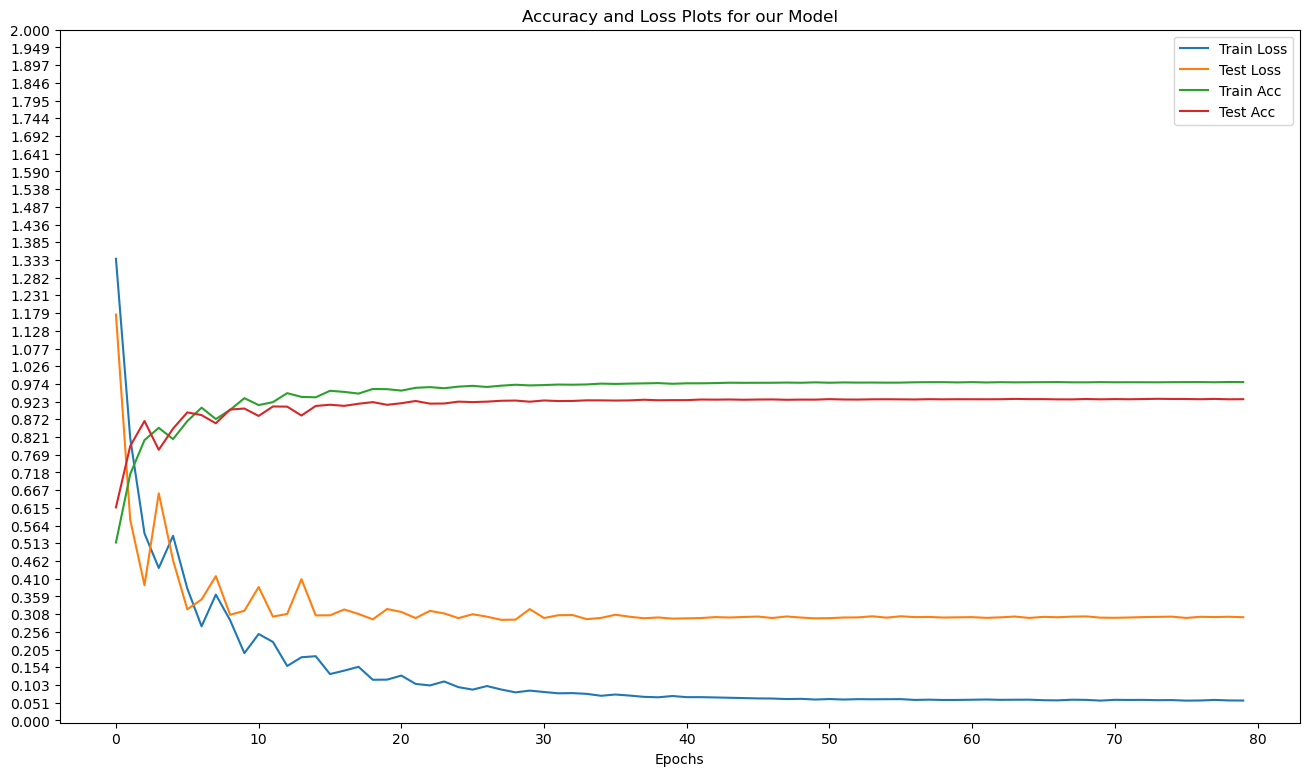

In [10]:
fig, ax = plt.subplots(figsize=(16,9))

plt.title('Accuracy and Loss Plots for our Model')
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Test Loss')
plt.plot(train_acc_history, label='Train Acc')  
plt.plot(val_acc_history, label='Test Acc')
plt.legend()
plt.xlabel("Epochs")
yticks = np.linspace(0, 2.0, num=40)
ax.set_yticks(yticks)
plt.show()

### Plotting learning rate from the cyclic scheduler over batches of data

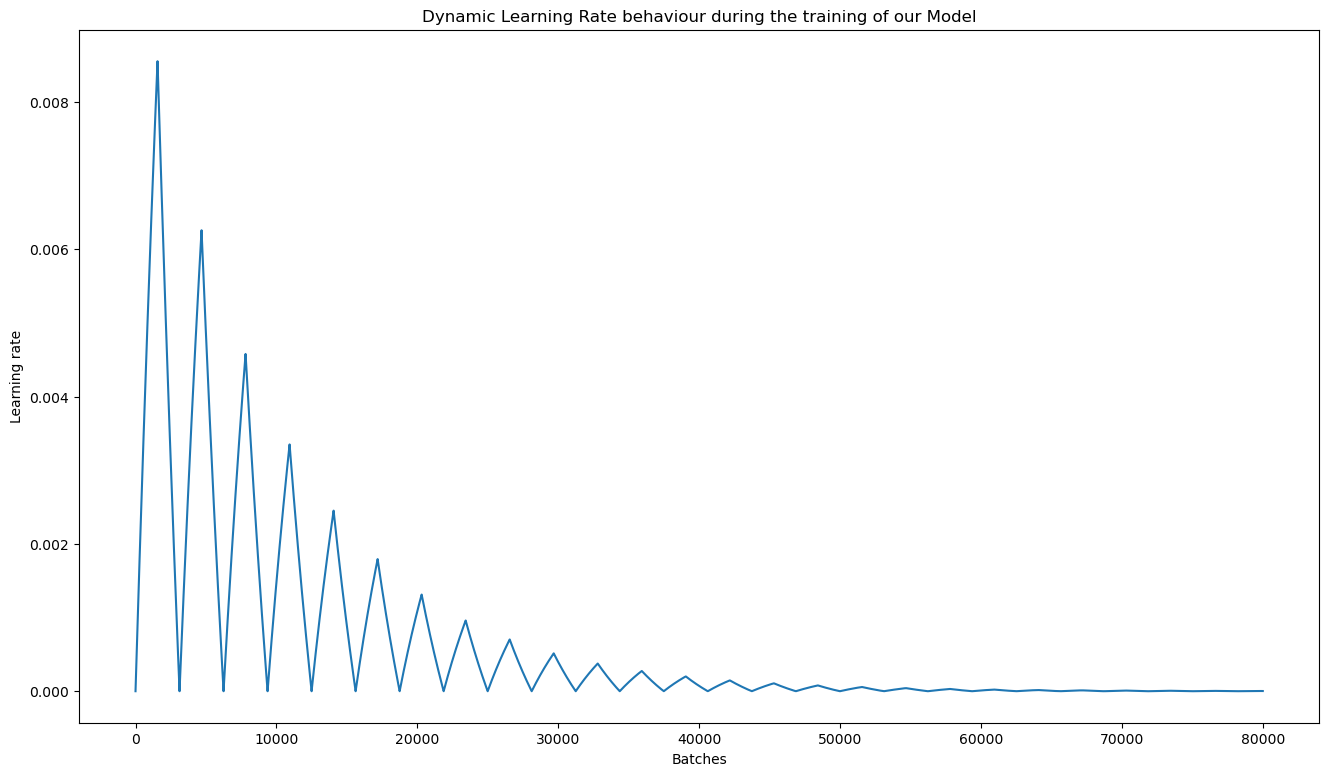

In [11]:
fig, ax = plt.subplots(figsize=(16,9))
plt.title('Dynamic Learning Rate behaviour during the training of our Model')
plt.plot(range(len(lr_tracker)), lr_tracker.values())
plt.xlabel('Batches')
plt.ylabel('Learning rate')
plt.show()

### Plotting confusion matrix for outputs

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'airplane'),
  Text(1, 0, 'automobile'),
  Text(2, 0, 'bird'),
  Text(3, 0, 'cat'),
  Text(4, 0, 'deer'),
  Text(5, 0, 'dog'),
  Text(6, 0, 'frog'),
  Text(7, 0, 'horse'),
  Text(8, 0, 'ship'),
  Text(9, 0, 'truck')])

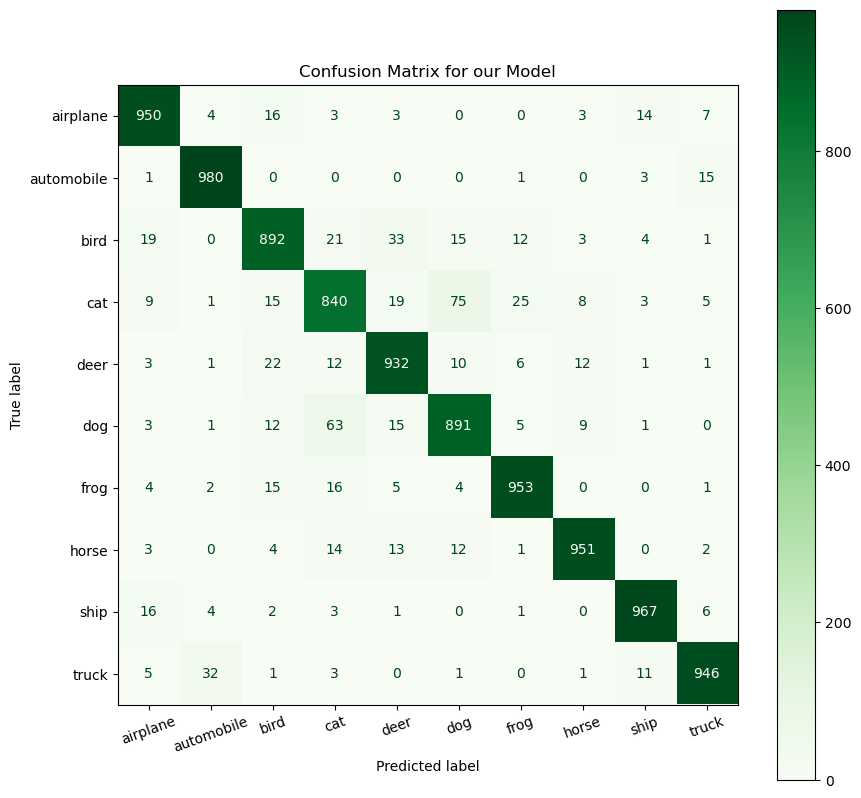

In [13]:
# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)
fig = plt.figure(figsize = (10, 10));
ax = fig.add_subplot(1, 1, 1);
ax.set_title('Confusion Matrix for our Model')
cm = ConfusionMatrixDisplay(cm, display_labels = classes);
cm.plot(values_format = 'd', cmap = 'Greens', ax = ax)
plt.xticks(rotation = 20)

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model_state_dict = torch.load('ahzam_net.pt')

model.load_state_dict(model_state_dict)

<All keys matched successfully>

In [15]:
# Prepare model for inference
model.eval()

model.to(device)

ResNet(
  (conv1): Conv2d(3, 42, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(42, 42, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.15, inplace=False)
      (conv2): Conv2d(42, 42, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(42, 42, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.15, inplace=False)
      (conv2): Conv2d(42, 42, kernel_size=(3, 3), stride=(

In [16]:
correct = 0
total = 0
with torch.no_grad():  # No need to compute gradients during evaluation
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

print(f'Accuracy of the network on the validation set: {100 * correct / total}%')

/home/sa8237/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Accuracy of the network on the validation set: 92.56%


#### Final accuracy of the model on CIFAR 10 data: 92.56%

## Making Inference on unseen data

In [17]:
import pickle

# Load the pickled test data
with open('cifar_test_nolabels.pkl', 'rb') as file:
    test_images = pickle.load(file)

# Checking the type and shape of the loaded data
print(type(test_images))

<class 'dict'>


In [18]:
# Retrieve and print a couple of keys
keys = list(test_images.keys())
sample_key_values = {key: test_images[key] for key in keys}

# Check the type and shape of the image data for these keys
for key, value in sample_key_values.items():
    print(f"Key: {key}, Type: {type(value)}, Shape: {value.shape if hasattr(value, 'shape') else 'N/A'}")

Key: b'data', Type: <class 'numpy.ndarray'>, Shape: (10000, 3072)
Key: b'ids', Type: <class 'numpy.ndarray'>, Shape: (10000,)


In [19]:
import torch
from torchvision import transforms
from PIL import Image
import csv
# import pandas as pd

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])



# Process all images for predictions
predictions = []
for i in range(len(test_images[b'data'])):
    # Reshape and transpose image data to (32, 32, 3)
    image_data = test_images[b'data'][i].reshape(3,32,32).transpose([1, 2, 0])
    image_data = transform(image_data).unsqueeze(0)  # Add batch dimension

    image_data = image_data.to(device)
    # Convert to PIL Image
    # Make prediction
    with torch.no_grad():
        output = model(image_data)
        _, predicted = torch.max(output, 1)
        predicted_label = predicted.item()
        predictions.append((test_images[b'ids'][i], predicted_label))



In [20]:
y_values = [y for _, y in predictions]

# Converting the list of y values to a set to remove duplicates
unique_y_values = set(y_values)

# Counting the number of unique y values
num_unique_y_values = len(unique_y_values)

print("Number of unique y values:", num_unique_y_values)

Number of unique y values: 10


In [21]:
frequency = {}

# Looping through the list to count each y value
for _, y in predictions:
    if y in frequency:
        frequency[y] += 1
    else:
        frequency[y] = 1

# Printing the frequency of each y value
for y_val, count in frequency.items():
    print(f"Frequency of {y_val}: {count}")

Frequency of 8: 1044
Frequency of 0: 960
Frequency of 3: 1146
Frequency of 4: 950
Frequency of 1: 967
Frequency of 9: 1094
Frequency of 2: 934
Frequency of 6: 864
Frequency of 7: 1031
Frequency of 5: 1010


In [ ]:
import csv
csv_file_path = 'predictions_ResNet18.csv'

# Write the predictions into the CSV file
with open(csv_file_path, 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(['ID', 'Labels'])  # Write the header
    for prediction in predictions:
        writer.writerow(prediction)
# Return the path to the saved CSV file
csv_file_path